# Setup

Change for the Lab

## Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Download the Data

In [4]:
# Download the data 
import os
import tarfile
import urllib.request
import warnings  # Import the warnings module

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


# Definition of how to fetch the data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)

    # Suppress the DeprecationWarning for tarfile extraction
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path, filter=None)
        housing_tgz.close()


In [5]:
# Execute fetching
fetch_housing_data()

In [6]:
import pandas as pd

# Definition of how to Load the housing csv from the path
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Create a Test Set

In [7]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [8]:
# Create the housing data frame
housing = load_housing_data()

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [11]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [12]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

    

# Data cleaning

In [13]:
from sklearn.impute import SimpleImputer

# Data cleaning 
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]

# Initialize the SimpleImputer for "total_bedrooms" column with the 'median' strategy
imputer = SimpleImputer(strategy="median")

# Fit the imputer on the 'total_bedrooms' column
imputer.fit(housing[["total_bedrooms"]])

# Transform only the 'total_bedrooms' column in sample_incomplete_rows
sample_incomplete_rows["total_bedrooms"] = imputer.transform(sample_incomplete_rows[["total_bedrooms"]])

# Optionally, check the imputation strategy used
print(imputer.strategy)

# Now you can replace the transformed values back into the original dataset
housing.loc[sample_incomplete_rows.index, "total_bedrooms"] = sample_incomplete_rows["total_bedrooms"]

# Final transformed dataset
housing_num = housing.copy()  # or use housing_tr to keep original data intact

housing_num = housing_num.drop("ocean_proximity", axis=1)

housing_num = housing_num.drop("income_cat", axis=1)

median


C:\Users\marco\AppData\Local\Temp\ipykernel_16408\607306170.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_incomplete_rows["total_bedrooms"] = imputer.transform(sample_incomplete_rows[["total_bedrooms"]])


In [14]:
from sklearn.preprocessing import OneHotEncoder

# Extract the 'ocean_proximity' column
housing_cat = housing[["ocean_proximity"]]

# Initialize the OneHotEncoder with dense output (not sparse)
cat_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the 'ocean_proximity' column
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# Custom Tranformers

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [16]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

In [17]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,2,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,5,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,2,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,2,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,3,6.096552,3.167241


## Transformation Pipelines

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [19]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [20]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [21]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [22]:
housing_prepared.shape

(16512, 16)

# Prepare the Data for Machine Learning Algorithms

# Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [24]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

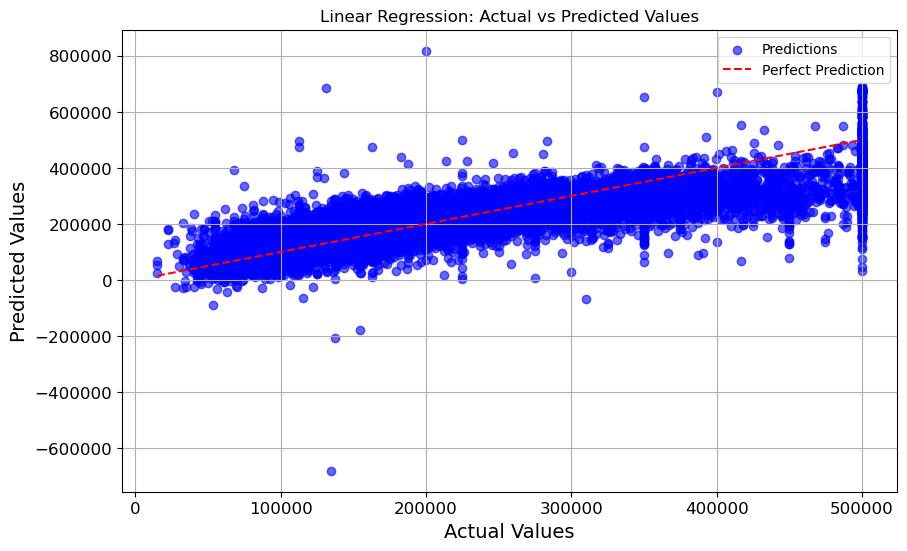

In [25]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Descission Tree Regressor

In [26]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [27]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

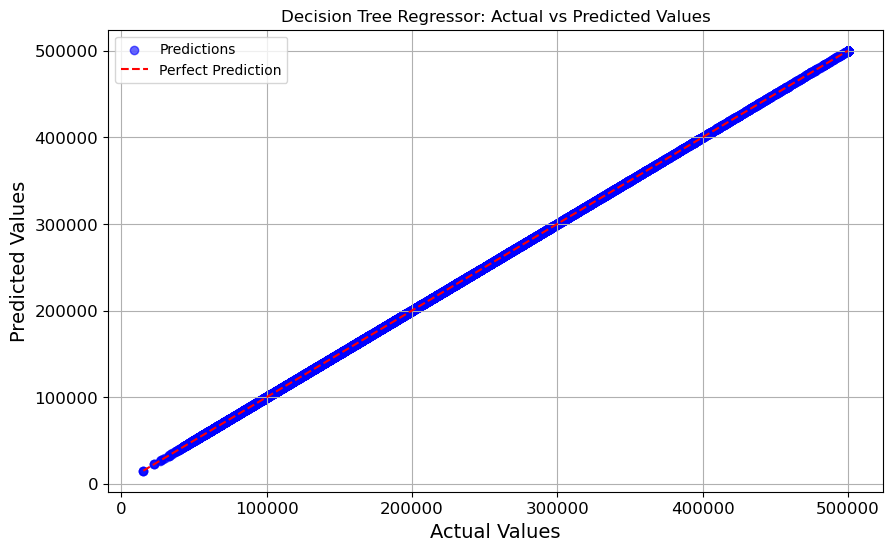

In [28]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Decision Tree Regressor: Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Random Forest Regressor 

In [29]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [30]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

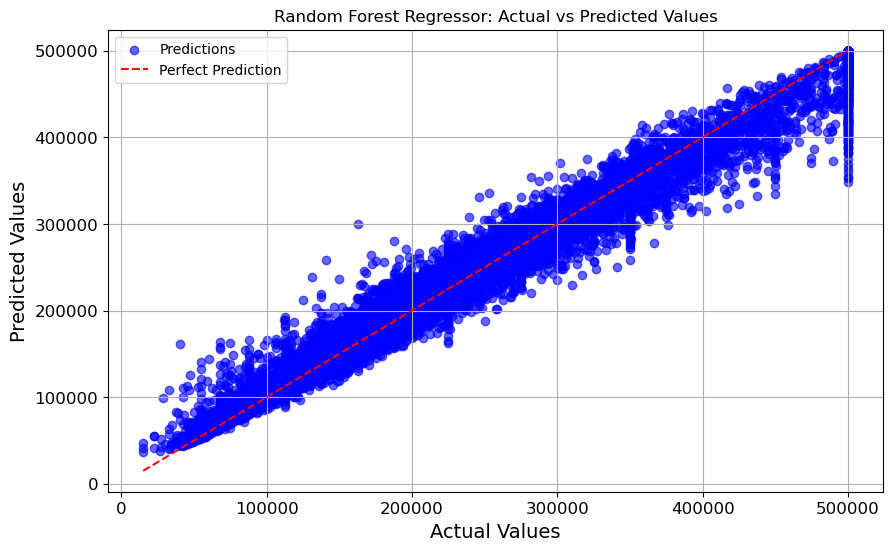

In [31]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regressor: Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Support Vector Machine Regressor

In [32]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291966

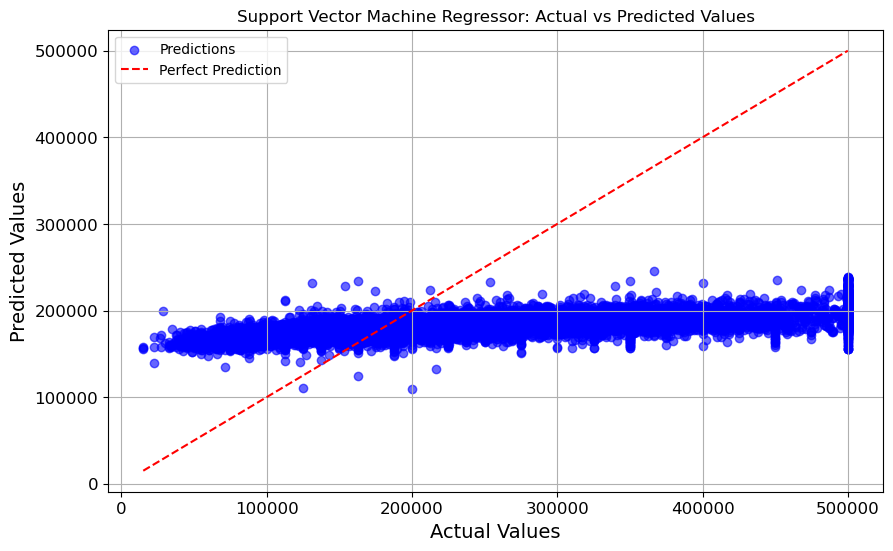

In [33]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Support Vector Machine Regressor: Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

## Better Evaluation Using Cross-Validation

In [34]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [35]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [36]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180634


In [37]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [38]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69104.079982
std       3036.132517
min      64114.991664
25%      67077.398482
50%      68718.763507
75%      71357.022543
max      73997.080502
dtype: float64

In [39]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 113168.96643781 111945.40954593]
Mean: 111814.1069260169
Standard deviation: 2600.840269089257


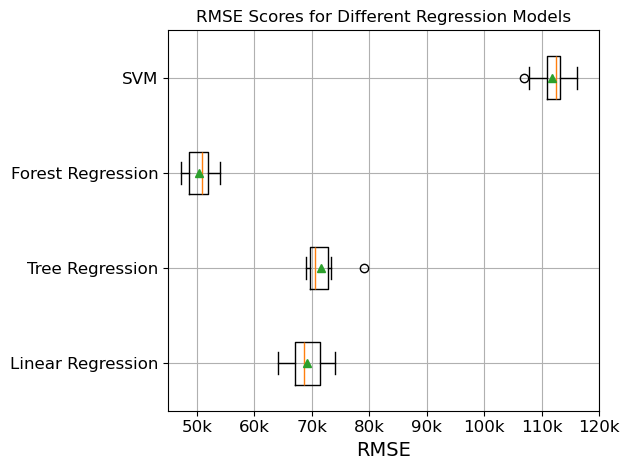

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Create one figure and axis object
fig, ax = plt.subplots()

# Create boxplot for all four regression methods on the same axis
ax.boxplot([lin_rmse_scores, tree_rmse_scores, forest_rmse_scores, svm_rmse_scores], 
           vert=False, showmeans=True)

# Set x-axis label and limits
ax.set_xlabel("RMSE")
ax.set_xlim(45000, 120000)  # Set x-axis limits

# Format x-axis tick labels to show shorter notation (e.g., 120k)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

# Set the y-axis labels (regression methods)
ax.set_yticklabels(["Linear Regression", "Tree Regression", "Forest Regression", "SVM"])

# Add grid for better readability
ax.grid(True)

# Set the title of the plot
ax.set_title("RMSE Scores for Different Regression Models")

# Show the plot
plt.tight_layout()  # Adjust layout if needed
plt.show()


# Lab 3

# Fine-Tune Your Model

## Grid Search 

### Linear Regression

In [83]:
from sklearn.model_selection import GridSearchCV

param_grid_linear = {
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'copy_X': [True, False]  # Whether to copy X before fitting
}


In [84]:
linear_reg = LinearRegression()

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_linear_reg = GridSearchCV(linear_reg, param_grid_linear, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_linear_reg.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [85]:
grid_search_linear_reg.best_params_

{'copy_X': True, 'fit_intercept': True}

In [86]:
grid_search_linear_reg.best_estimator_

LinearRegression()

### Decission Tree Regressor

In [137]:
param_grid_tree = {
    'max_depth': [10, 50, 100, None],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [10 , 20, 50],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider for the best split
    'ccp_alpha': [0.0, 0.1, 0.2]  # Complexity parameter used for Minimal Cost-Complexity Pruning
}

In [138]:
tree_reg = DecisionTreeRegressor(random_state=42)

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_tree_reg = GridSearchCV(tree_reg, param_grid_tree, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_tree_reg.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2],
                         'max_depth': [10, 50, 100, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [10, 20, 50],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [139]:
grid_search_tree_reg.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 50,
 'max_features': None,
 'min_samples_leaf': 20,
 'min_samples_split': 2}

In [140]:
grid_search_tree_reg.best_estimator_

DecisionTreeRegressor(max_depth=50, min_samples_leaf=20, random_state=42)

### Random Forrest Regressor

In [142]:
param_grid_forest = [
    {'n_estimators': [3, 10, 30, 500], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [1, 3, 10], 'max_features': [2, 3, 4]},
  ]

In [143]:
forest_reg = RandomForestRegressor(random_state=42)

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_forest_reg = GridSearchCV(forest_reg, param_grid_forest, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_forest_reg.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 500]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [1, 3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [144]:
grid_search_forest_reg.best_params_

{'max_features': 6, 'n_estimators': 500}

In [145]:
grid_search_forest_reg.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=500, random_state=42)

In [146]:
cvres = grid_search_forest_reg.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
51407.51843908147 {'max_features': 2, 'n_estimators': 500}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
49398.05779277547 {'max_features': 4, 'n_estimators': 500}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
49018.62601875434 {'max_features': 6, 'n_estimators': 500}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
49027.677526991414 {'max_features': 8, 'n_estimators': 500}
79001.4972210543 {'bootstrap': False, 'max_features': 2, 'n_estimators

### Support Vector Machine Regressor

In [76]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'epsilon': [0.1, 0.2, 0.5, 1.0],  # Epsilon in the epsilon-SVR model
}

In [77]:
svm_reg = SVR(kernel="linear")

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_svm_reg = GridSearchCV(svm_reg, param_grid_svm, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_svm_reg.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=SVR(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100],
                         'epsilon': [0.1, 0.2, 0.5, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [78]:
grid_search_svm_reg.best_params_

{'C': 100, 'epsilon': 0.1}

In [79]:
grid_search_svm_reg.best_estimator_

SVR(C=100, kernel='linear')

RMSE for Linear Regression: 74866.78655971572


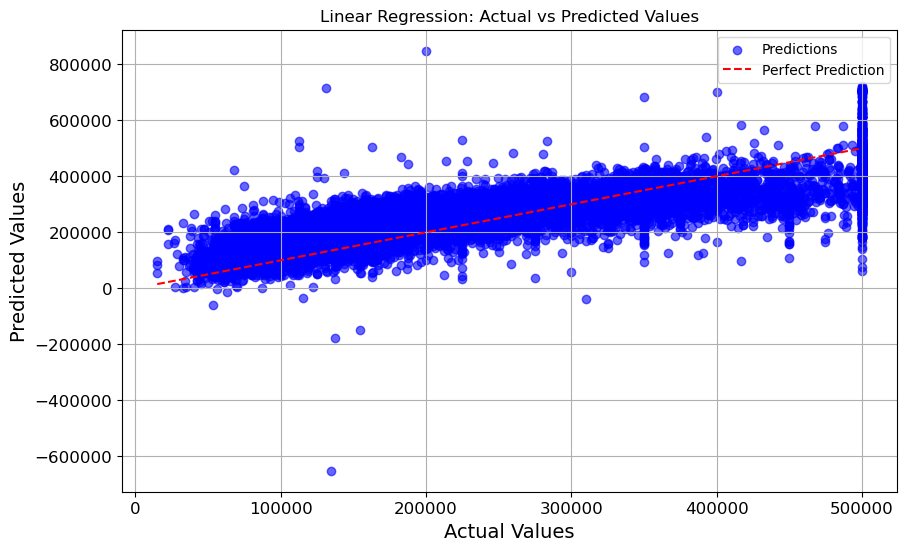

RMSE for Decision Tree: 48508.879901383494


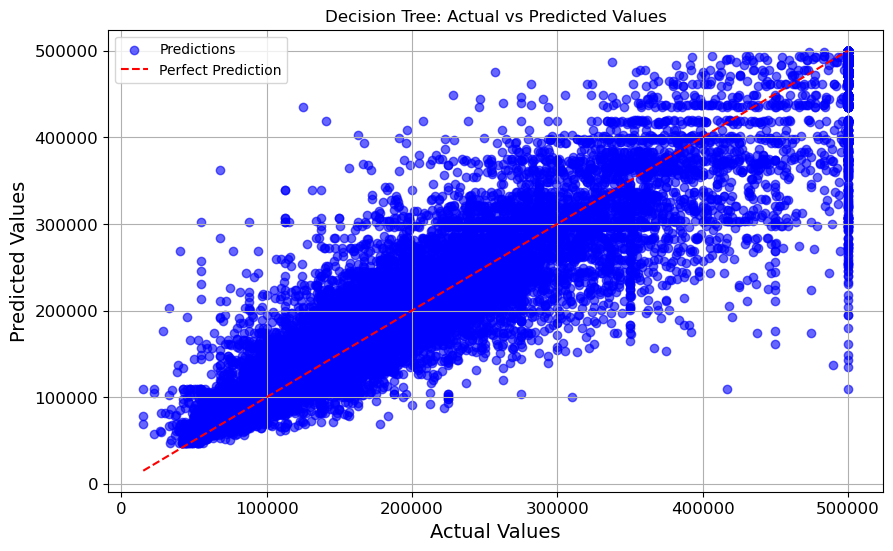

RMSE for Random Forest: 17856.180939935417


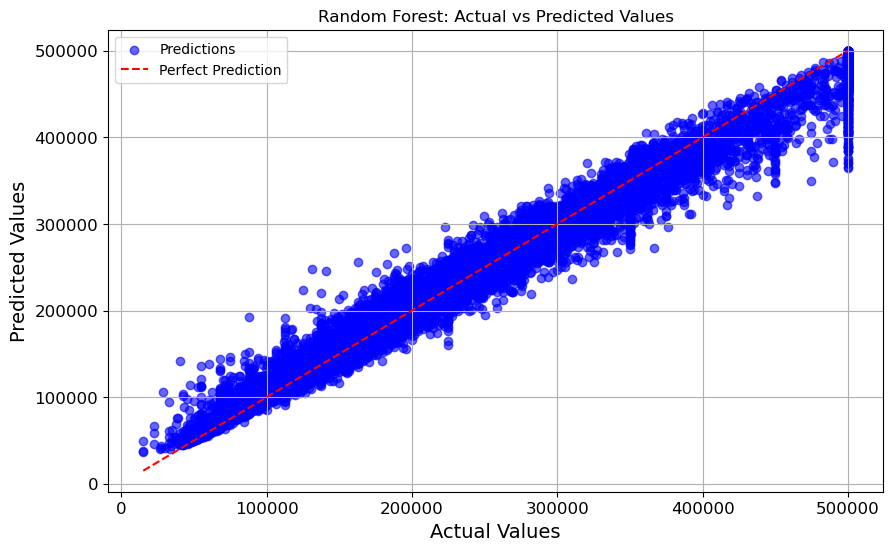

RMSE for Support Vector Machine: 70717.7677487401


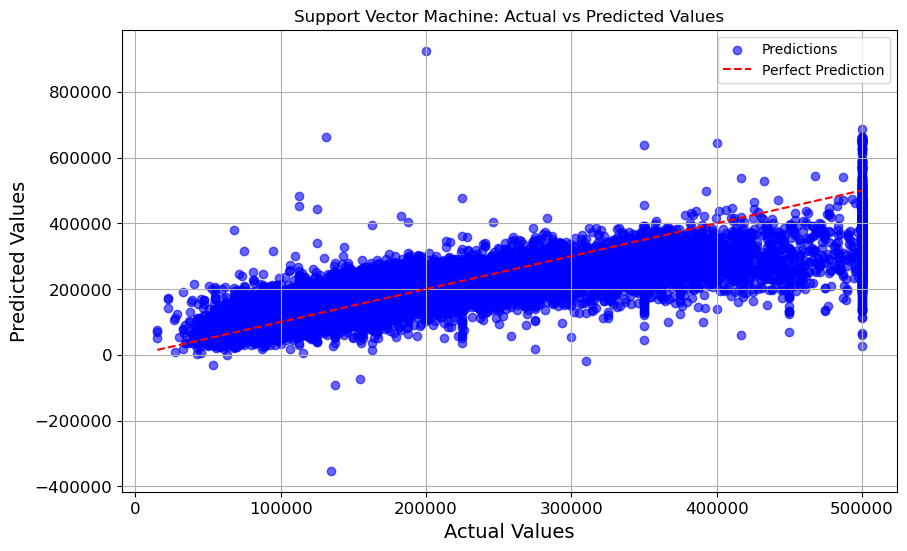

In [156]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Helper function to evaluate models
def evaluate_model(model, housing_prepared, housing_labels, model_name):
    housing_predictions = model.predict(housing_prepared)
    rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
    print(f"RMSE for {model_name}: {rmse}")
    
    # Plot Actual vs Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
    plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name}: Actual vs Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate the best models
evaluate_model(grid_search_linear_reg.best_estimator_, housing_prepared, housing_labels, "Linear Regression")
evaluate_model(grid_search_tree_reg.best_estimator_, housing_prepared, housing_labels, "Decision Tree")
evaluate_model(grid_search_forest_reg.best_estimator_, housing_prepared, housing_labels, "Random Forest")
evaluate_model(grid_search_svm_reg.best_estimator_, housing_prepared, housing_labels, "Support Vector Machine")

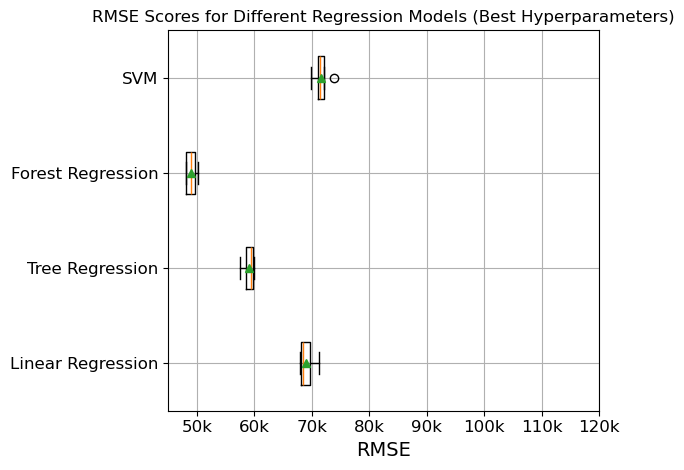

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Extract the best scores from each model's GridSearchCV
best_index_linear = grid_search_linear_reg.best_index_
best_index_tree = grid_search_tree_reg.best_index_
best_index_forest = grid_search_forest_reg.best_index_
best_index_svm = grid_search_svm_reg.best_index_

# Extract the scores for each model's best hyperparameters
best_scores_linear = grid_search_linear_reg.cv_results_['split0_test_score'][best_index_linear], \
                     grid_search_linear_reg.cv_results_['split1_test_score'][best_index_linear], \
                     grid_search_linear_reg.cv_results_['split2_test_score'][best_index_linear], \
                     grid_search_linear_reg.cv_results_['split3_test_score'][best_index_linear], \
                     grid_search_linear_reg.cv_results_['split4_test_score'][best_index_linear]

best_scores_tree = grid_search_tree_reg.cv_results_['split0_test_score'][best_index_tree], \
                   grid_search_tree_reg.cv_results_['split1_test_score'][best_index_tree], \
                   grid_search_tree_reg.cv_results_['split2_test_score'][best_index_tree], \
                   grid_search_tree_reg.cv_results_['split3_test_score'][best_index_tree], \
                   grid_search_tree_reg.cv_results_['split4_test_score'][best_index_tree]

best_scores_forest = grid_search_forest_reg.cv_results_['split0_test_score'][best_index_forest], \
                     grid_search_forest_reg.cv_results_['split1_test_score'][best_index_forest], \
                     grid_search_forest_reg.cv_results_['split2_test_score'][best_index_forest], \
                     grid_search_forest_reg.cv_results_['split3_test_score'][best_index_forest], \
                     grid_search_forest_reg.cv_results_['split4_test_score'][best_index_forest]

best_scores_svm = grid_search_svm_reg.cv_results_['split0_test_score'][best_index_svm], \
                  grid_search_svm_reg.cv_results_['split1_test_score'][best_index_svm], \
                  grid_search_svm_reg.cv_results_['split2_test_score'][best_index_svm], \
                  grid_search_svm_reg.cv_results_['split3_test_score'][best_index_svm], \
                  grid_search_svm_reg.cv_results_['split4_test_score'][best_index_svm]

# Convert negative MSE to RMSE for the best scores
lin_rmse_scores = np.sqrt(-np.array(best_scores_linear))
tree_rmse_scores = np.sqrt(-np.array(best_scores_tree))
forest_rmse_scores = np.sqrt(-np.array(best_scores_forest))
svm_rmse_scores = np.sqrt(-np.array(best_scores_svm))

# Create one figure and axis object
fig, ax = plt.subplots()

# Create boxplot for all four regression methods on the same axis
ax.boxplot([lin_rmse_scores, tree_rmse_scores, forest_rmse_scores, svm_rmse_scores], 
           vert=False, showmeans=True)

# Set x-axis label and limits
ax.set_xlabel("RMSE")
ax.set_xlim(45000, 120000)  # Set x-axis limits

# Format x-axis tick labels to show shorter notation (e.g., 120k)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

# Set the y-axis labels (regression methods)
ax.set_yticklabels(["Linear Regression", "Tree Regression", "Forest Regression", "SVM"])

# Add grid for better readability
ax.grid(True)

# Set the title of the plot
ax.set_title("RMSE Scores for Different Regression Models (Best Hyperparameters)")

# Show the plot
plt.tight_layout()  # Adjust layout if needed
plt.show()


In [ ]:
# Extract the best estimator from the grid search
best_tree_model = grid_search_tree_reg.best_estimator_

# Make predictions using the best estimator
y_pred_tree = best_tree_model.predict(housing_prepared)

# Plotting the Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, y_pred_tree, color="blue", alpha=0.5, label="Predictions")
plt.plot([housing_labels.min(), housing_labels.max()], [housing_labels.min(), housing_labels.max()], 'r--', lw=2, label="Perfect Prediction")

# Adding labels, title, legend, and grid
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regressor: Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
rnd_search.best_params_

## Evaluate Your System on the Test Set

In [168]:
final_model = grid_search_forest_reg.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [169]:
final_rmse

46756.12898564637

In [159]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([44800.27118461, 48633.39282047])

In [160]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(44800.27118461064, 48633.39282047004)

In [161]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(44800.85731213183, 48632.85288303375)